<a href="https://colab.research.google.com/github/itsmeeeeeee/MML/blob/main/MMF_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from PIL import Image, ImageFile


import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch

# Load labels from CSV
file_path_labels = "/content/drive/MyDrive/MultimodalNLP/projekt/data/labels.csv"
labeled_data = pd.read_csv(file_path_labels)
labels = labeled_data['overall_sentiment'].values

# Define your existing mapping
label_mapping = {
    "very_negative": 0,
    "negative": 0,
    "positive": 1,
    "very_positive": 1
}

# Get valid indices for labels that exist in the mapping
valid_indices = [i for i, label in enumerate(labels) if label in label_mapping]
filtered_labels = [labels[i] for i in valid_indices]

# Apply the mapping to convert filtered text labels to numeric labels
numeric_labels = np.array([label_mapping[label] for label in filtered_labels])

# Convert labels to a torch tensor
numeric_labels = torch.tensor(numeric_labels, dtype=torch.long)
print("numeric labels:", numeric_labels.shape)

# Load image features
file_path_im = "/content/drive/MyDrive/MultimodalNLP/projekt/features_data/image_features_restnet.npy"
image_features = np.load(file_path_im)

# Load text features
file_path_emb = "/content/drive/MyDrive/MultimodalNLP/projekt/features_data/text_features_bert.npy"
text_features = np.load(file_path_emb)

# Filter image and text features using valid indices
filtered_image_features = torch.tensor(image_features[valid_indices], dtype=torch.float32)
filtered_text_features = torch.tensor(text_features[valid_indices], dtype=torch.float32)

print("Filtered Image features:", filtered_image_features.shape)
print("Filtered Text features:", filtered_text_features.shape)


numeric labels: torch.Size([4791])
Filtered Image features: torch.Size([4791, 1000])
Filtered Text features: torch.Size([4791, 768])


In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


"""
Split the initial dataset into training and preliminary testing sets.
20% of the data is reserved for preliminary testing, and 80% is used for training.
"""
train_text, prelim_test_text, train_image, prelim_test_image, train_labels, prelim_test_labels = train_test_split(
    filtered_text_features, filtered_image_features, numeric_labels, test_size=0.2, random_state=42
)

"""
Further split the preliminary testing data into validation and final test sets.
40% of the preliminary test data is used for validation and 60% for the final testing.
"""
val_text, test_text, val_image, test_image, val_labels, test_labels = train_test_split(
    prelim_test_text, prelim_test_image, prelim_test_labels, test_size=0.6, random_state=42
)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

# DataLoaders für Training, Validierung und Test
train_dataset = TensorDataset(train_text, train_image, train_labels)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(val_text, val_image, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(test_text, test_image, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, text_dim, image_dim, hidden_dim, num_classes):
        super(MLPClassifier, self).__init__()
        # Define linear layers to process text and image inputs
        self.text_model = nn.Linear(text_dim, hidden_dim)
        self.image_model = nn.Linear(image_dim, hidden_dim)

        # Define MLP layers to process combined features
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 4)  # First MLP layer
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)  # Second MLP layer
        self.fc3 = nn.Linear(hidden_dim * 2, num_classes)     # Output layer

    def forward(self, text_features, image_features):
        # Process text and image features through linear layers
        text_features = self.text_model(text_features)
        image_features = self.image_model(image_features)

        # Combine the features from both modalities
        combined_features = torch.cat([text_features, image_features], dim=1)

        # Process combined features through MLP layers
        combined_features = F.relu(self.fc1(combined_features))
        combined_features = F.relu(self.fc2(combined_features))
        output = self.fc3(combined_features)
        return output


In [7]:
# Model instantiation and training
model = MLPClassifier(text_dim=768, image_dim=1000, hidden_dim=128, num_classes=2)
#model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [8]:
"""
Training and validation loop for a Multimodal Fusion Classifier.
The code for the loop structure is adapted from Sebastian Raschka's guide on training loops in PyTorch:
https://sebastianraschka.com/faq/docs/training-loop-in-pytorch.html

Early stopping implementation inspired by: https://keras.io/api/callbacks/early_stopping/
"""

import torch
import numpy as np

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler, patience=10):
    trigger_times = 0  # Counter for the number of times validation loss has not improved
    best_val_loss = float('inf')  # Initialize the best validation loss
    best_model_state = None  # To store the best model state

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for texts, images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients to zero for a new optimization step
            outputs = model(texts, images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()  # Accumulate loss over the epoch

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for texts, images, labels in val_loader:
                outputs = model(texts, images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        average_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}: Training Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f}')

        scheduler.step(average_val_loss)

        # Update the trigger counter and check for early stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model_state = model.state_dict()  # Save the best model state
            trigger_times = 0  # Reset the trigger times since we found a new best
        else:
            trigger_times += 1  # Increment the trigger times
            if trigger_times >= patience:
                print('Early stopping triggered!')
                break

    # Load the best model state back into the model
    if best_model_state:
        model.load_state_dict(best_model_state)
    return model


#best_model_lstm=train_model(model, train_loader, val_loader, 50, optimizer, criterion, scheduler, patience=10)
best_model_mlp=train_model(model, train_loader, val_loader, 50, optimizer, criterion, scheduler, patience=10)



Epoch 1: Training Loss: 0.4339 | Validation Loss: 0.3868
Epoch 2: Training Loss: 0.4025 | Validation Loss: 0.3896
Epoch 3: Training Loss: 0.4002 | Validation Loss: 0.3858
Epoch 4: Training Loss: 0.3899 | Validation Loss: 0.3910
Epoch 5: Training Loss: 0.3817 | Validation Loss: 0.3895
Epoch 6: Training Loss: 0.3773 | Validation Loss: 0.4102
Epoch 7: Training Loss: 0.3830 | Validation Loss: 0.3945
Epoch 8: Training Loss: 0.3721 | Validation Loss: 0.4080
Epoch 9: Training Loss: 0.3707 | Validation Loss: 0.3973
Epoch 10: Training Loss: 0.3552 | Validation Loss: 0.4266
Epoch 11: Training Loss: 0.3587 | Validation Loss: 0.4027
Epoch 12: Training Loss: 0.3551 | Validation Loss: 0.4240
Epoch 13: Training Loss: 0.3335 | Validation Loss: 0.4291
Early stopping triggered!


In [9]:
"""
Code is based on guidance from:
- https://machinelearningmodels.org/evaluating-the-accuracy-score-of-your-machine-learning-model/
- https://scikit-learn.org/stable/modules/model_evaluation.html#

"""

import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, loader):
    model.eval()
    all_outputs = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Deaktiviere die Gradientenberechnung
        for texts, images, labels in loader:
            outputs = model(texts, images)
            _, predicted = torch.max(outputs.data, 1)
            all_outputs.append(outputs.cpu().numpy())
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Berechne Metriken mit 'macro' Durchschnitt
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro')
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1 = f1_score(all_labels, all_predictions, average='macro')
    test_conf_matrix = confusion_matrix(all_labels, all_predictions)

    print("Test Accuracy:", test_accuracy)
    print("Precision (Macro):", test_precision)
    print("Recall (Macro):", test_recall)
    print("F1 Score (Macro):", test_f1)
    return test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix

# Annahme: Model und Test-Loader sind anderswo definiert
test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(best_model_mlp, test_loader)


Test Accuracy: 0.8958333333333334
Precision (Macro): 0.44947735191637633
Recall (Macro): 0.4980694980694981
F1 Score (Macro): 0.47252747252747257


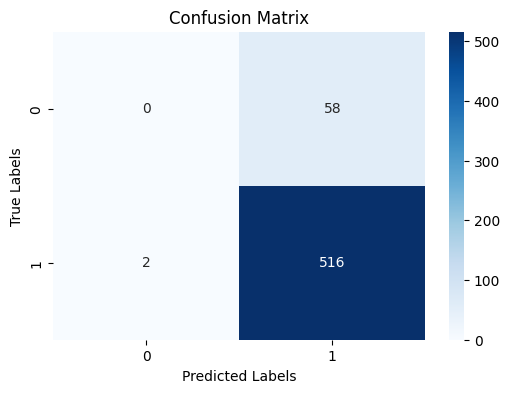

In [10]:
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()